<a href="https://colab.research.google.com/github/visoutre/ai-notebooks/blob/main/Stable_Diffusion_Batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stable Diffusion Batch by [visoutre](https://www.reddit.com/user/visoutre) and [FutureArt](https://twitter.com/future__art) and [Pharmapsychotic](https://twitter.com/pharmapsychotic)

<b> v 2.1.2, last updated 8/28/22 </b>

<i> Original Collab info: v 1.1.2, last updated 8/24/22 </i>
<br>
<br>

Credits & Updated Features:
- most of the work was done by FutureArt and Pharmapsychotic, I added the feature for img2img to be processed in bulk and to use template prompts

- I also adding randomization options for quickly generating a large variety of concepts with a single click

- Key Features Include:
 - process a single image or multiple images, single prompts or multiple prompts
 - randomizing starting keyword in the prompts for variations on a theme
 - processing sequential guidance scales and image strengths on a seed for data
 - randomizing guidance scales and image strengths for exploration
 - processing a list of prompts with a corresponding image for consistency
 - processing a list of prompts with a random image for creativity
 - save prompt templates which can be quickly loaded
 - cycle through multiple prompt templates with multiple input images/prompts
 - the prompt cycling feature are like having your own art design team who can create different styles or follow a style!

- Upcoming Plans
  - test useability and bugs
  - port locally to use with an RTX / better GUI (long term)
  - template for body parts to make compositing crops quicker and batched (often I upres face, hands, armor/clothes x2)

- Note from original collab file:
 - Generate images with CompVis/Stability [Stable Diffusion](https://github.com/CompVis/stable-diffusion) with bonus [KLMS sampling](https://github.com/crowsonkb/k-diffusion.git) from [@RiversHaveWings](https://twitter.com/RiversHaveWings).

<br>

### How to download the Stable Diffusion model:

- Visit https://huggingface.co/CompVis/stable-diffusion-v-1-4-original and agree to the terms and conditions.
- Click the **Files and versions** tab
- Click **stable-diffusion-v-1-4-original**
- Click the **download** link where it says *This file is stored with Git LFS . It is too big to display, but you can still download it.*
- If you have [Google Drive for desktop](https://www.google.com/drive/download/) (highly recommended), you can save it directly to your **AI/models** directory.
  - Otherwise, download it and re-upload it to your [Google Drive](https://drive.google.com) in the **AI/models** directory. (This is risky, as the upload may time out.)

# 1. Setup
- simply run the arrow here, no need to open this section or mess with settings

In [ ]:
#@title Check GPU
!nvidia-smi -L

In [ ]:
#@title Mount Google Drive and Prepare Folders
from google.colab import drive
drive.mount('/content/gdrive')
outputs_path = "/content/gdrive/MyDrive/AI/StableDiffusionBatch"
!mkdir -p $outputs_path
!mkdir -p "init_image"
print(f"Outputs will be saved to {outputs_path}")

In [ ]:
#@title Installation
!pip install pytorch-lightning torch-fidelity
!pip install numpy omegaconf einops kornia pytorch-lightning
!pip install albumentations transformers
!pip install ftfy jsonmerge resize-right torchdiffeq tqdm

!git clone https://github.com/CompVis/stable-diffusion
%cd stable-diffusion/
!git clone https://github.com/CompVis/taming-transformers
!git clone https://github.com/openai/CLIP.git
!git clone https://github.com/crowsonkb/k-diffusion.git

import sys
sys.path.append(".")
sys.path.append("./CLIP")
sys.path.append('./taming-transformers')
sys.path.append('./k-diffusion')

!echo '' > ./k-diffusion/k_diffusion/__init__.py


In [ ]:
#@markdown You need to get the model weights yourself and put on Google Drive or this Colab instance
checkpoint_model_file = "/content/gdrive/MyDrive/AI/models/sd-v1-4.ckpt" #@param {type:"string"}

In [ ]:
#@title Define helper functions

import argparse, gc, json, os, random, sys, time, glob, requests
import torch
import torch.nn as nn
import numpy as np
import PIL
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from IPython.display import display, clear_output
from itertools import islice
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from torch.cuda.amp import autocast
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from k_diffusion.sampling import sample_lms
from k_diffusion.external import CompVisDenoiser


def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

class CFGDenoiser(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.inner_model = model

    def forward(self, x, sigma, uncond, cond, cond_scale):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        cond_in = torch.cat([uncond, cond])
        uncond, cond = self.inner_model(x_in, sigma_in, cond=cond_in).chunk(2)
        return uncond + (cond - uncond) * cond_scale

class config():
    def __init__(self):
        self.ckpt = checkpoint_model_file
        self.config = 'configs/stable-diffusion/v1-inference.yaml'
        self.ddim_eta = 0.0
        self.ddim_steps = 100
        self.fixed_code = True
        self.init_img = None
        self.n_iter = 1
        self.n_samples = 1
        self.outdir = ""
        self.precision = 'full' # 'autocast'
        self.prompt = ""
        self.sampler = 'klms'
        self.scale = 7.5
        self.seed = 42
        self.strength = 0.75 # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
        self.H = 512
        self.W = 512
        self.C = 4
        self.f = 8
      
def load_img(path, w, h):
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        if os.path.isdir(path):
            files = [file for file in os.listdir(path) if file.endswith('.png') or file .endswith('.jpg')]
            path = os.path.join(path, random.choice(files))
            print(f"Chose random init image {path}")
        image = Image.open(path).convert('RGB')
    image = image.resize((w, h), Image.LANCZOS)
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

opt = config()
config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
batch_idx = 0
sample_idx = 0

def generate(opt):
    global sample_idx
    seed_everything(opt.seed)
    os.makedirs(opt.outdir, exist_ok=True)

    if opt.sampler == 'plms':
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    model_wrap = CompVisDenoiser(model)       
    batch_size = opt.n_samples
    prompt = opt.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]
    init_latent = None

    if opt.init_img != None and opt.init_img != '':
        init_image = load_img(opt.init_img, opt.W, opt.H).to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

    sampler.make_schedule(ddim_num_steps=opt.ddim_steps, ddim_eta=opt.ddim_eta, verbose=False)

    t_enc = int(opt.strength * opt.ddim_steps)

    start_code = None
    if opt.fixed_code and init_latent == None:
        start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

    precision_scope = autocast if opt.precision == "autocast" else nullcontext

    images = []
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for n in range(opt.n_iter):
                    for prompts in data:
                        uc = None
                        if opt.scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)

                        if init_latent != None:
                            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                            samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,)
                        else:

                            if opt.sampler == 'klms':
                                print("Using KLMS sampling")
                                shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                                sigmas = model_wrap.get_sigmas(opt.ddim_steps)
                                model_wrap_cfg = CFGDenoiser(model_wrap)
                                x = torch.randn([opt.n_samples, *shape], device=device) * sigmas[0]
                                extra_args = {'cond': c, 'uncond': uc, 'cond_scale': opt.scale}
                                samples = sample_lms(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False)
                            else:
                                shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                                samples, _ = sampler.sample(S=opt.ddim_steps,
                                                                conditioning=c,
                                                                batch_size=opt.n_samples,
                                                                shape=shape,
                                                                verbose=False,
                                                                unconditional_guidance_scale=opt.scale,
                                                                unconditional_conditioning=uc,
                                                                eta=opt.ddim_eta,
                                                                x_T=start_code)

                        x_samples = model.decode_first_stage(samples)
                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            images.append(Image.fromarray(x_sample.astype(np.uint8)))
                            filepath = os.path.join(opt.outdir, f"{batch_name}({batch_idx})_{sample_idx:04} {opt.seed}.png")#####
                            print(f"Saving to {filepath}")
                            Image.fromarray(x_sample.astype(np.uint8)).save(filepath)
                            sample_idx += 1
    return images


# 2. Information on How to Use
- this section only contains reminders and tips on usage, section 3 is the working code

In [ ]:
#@title Prompting:
##@markdown

##@markdown Shared Prompt Ending:
#@markdown 1): folder name where this session will store the images:`<br>
1a) outputFolder = "upres_portraits4" #@param {type:"string"}

#<br>
#@markdown

#@markdown ---------------------------------------------------- Prompt Settings: ----------------------------------------------------
#<br>
#@markdown Note: Your prompt must be 77 tokens or less <br>
<br>
#@markdown 2): There's many options for splitting up the prompts:<br>
#<br>
#@markdown - 2a):`midDetails`: includes keywords to create higher detailed results`<br>
#<br>
#@markdown - 2b): `endingStyle`: includes art styles or artist names`<br>
#<br>
#@markdown - 2c): `randomStart`: is an initial word that is randomly selected to go at the start of the prompt`<br>
#@markdown  - I recommend 2 ways to use randomStart:`<br>
#@markdown  - 1) use a list of multiple emotions or elements (ex. icy, firey, rainy)`<br>
#@markdown  - 2) leave only a single option if you have a consistent theme (ex. 'female') `<br>
#<br>
#@markdown  - 2d): `randomEnd`: goes at the end of all prompts. Can leave it blank or find a use for it) `<br>
#<br>
#@markdown NOTE: you don't have to split your prompts with these seperate fields. You can simply put the whole thing in midDetails or in the batch prompt list too`<br>
#<br>
#<br>
#@markdown  Example of How Prompts Combine: 
#@markdown - [randomStart] + [batchPrompt] + [midDetails] + [endingStyle] + [randomEnd]`<br>
#<br>
#@markdown - `Example 1:` [pearlescent] [jellyfish in space], [digital art, concept art...], [by Alex Ross...]`<br>
#@markdown - `Example 2:` [pearlescent] [Lamborghini], [digital art, concept art...], [by Alex Ross...]`<br>
#@markdown - `Example 3:` [glowing] [frogs on lily pads], [digital art, concept art...], [by Alex Ross...]`<br>
#@markdown - Notice in the examples the first word is random and the detail + style words are consistent. 
#@markdown - The batch prompts are set up in a list a seperate cell`<br>
#<br>

2a) midDetails = "digital art, concept art, smooth, sharp focus, high definition, rendered in Octane" #@param {type:"string"}
2b) endingStyle = "illustration, art by artgerm and greg rutkowski and alphonse mucha" #@param {type:"string"}
2c) randomStart = "female" #@param {type:"string"}
2d) randomEnd = "" #@param {type:"string"}

#<br>
#@markdown

#@markdown ---------------------------------------------------- Basic Settings: ----------------------------------------------------
#<br>
#@markdown `width and height`:
#@markdown - image dimensions. range of 512-768 is best <br>
#<br>
#@markdown `guidance_scale`: 
#@markdown - strength of text prompt. 14 is good, 20 can have greater realism. 7 was beta default<br>

#<br>
#@markdown `steps`:
#@markdown - number of diffusion steps. more takes longer, but has better detail. test with 5-20 and use 50-80. rarely exceed 100<br>
#<br>
#@markdown `number_of_images`: 
#@markdown - how many images you want to generate in this batch<br>
#<br>
#@markdown `number_of_repeats`: 
#@markdown - how many rounds of iterating through the prompt list. the prompts always run from first to last of each before repeating<br>
#<br>
#@markdown `sampler`: 
#@markdown - it seems klms is default, but sometime of my results worked better with ddim, especially portraits<br>
#<br>

width = 700 #@param {type:"integer"}
height = 700 #@param {type:"integer"}
width_height = [width, height] # param{type: 'raw'}
guidance_scale = 14 #@param {type:"slider", min:0, max:20, step:0.5}
steps = 70 #@param {type:"integer"}
samples_per_batch = 1 # not exposed, you can do 2 or more based on GPU ram, if get CUDA out of memory need to restart runtime
number_of_images = 1 #param {type:"integer"}
number_of_repeats = 3 #@param {type:"integer"}
sampler = 'ddim' #@param ["klms","plms", "ddim"]
ddim_eta = 0.75 # param {type:"number"}

#<br>
#@markdown

#@markdown ----------------------------------------------------Init image ----------------------------------------------------<br>
#@markdown Note: you must upload the image(s) to the init_image folder on the left Files menu<br>
#<br>
#@markdown randomizeImageFromFolder: 
#@markdown  - leave unchecked to go through the list of images that are lined up with the prompt, or set to randomize to pull a random image to go with your prompts`<br>
#<br>
#@markdown - some notes on randomization:<br>
#@markdown  - if you leave randomization off, make sure your count of images matches the number of prompts in both lists<br>
#@markdown  - if you randomize the init_images, then you don't have to have the matching # of prompts to image. You could have 3 images and 100 prompts<br>
#<br>
#@markdown `initial_image`: 
#@markdown - if you want to work with a single image without setting up the list array, then you can enter the image name/extension here<br>
#@markdown - otherwise you can leave this field blank<br>
#<br>
#@markdown `init_strength`: * IMPORTANT * I use this option the most<br>
#@markdown - Adjust the intensity of how much the input image influences the result<br>
#@markdown - 0 means no input image is used. range 0.1-0.3 follows loose for creativity. 0.45-0.7 follows image closer for consistency<br>
randomizeImageFromFolder = False#@param{type:"boolean"}
initial_image = "" #@param {type:"string"}
init_image_or_folder = "/content/init_image/" + initial_image
init_strength = 0.78 #@param {type:"number"}

#@markdown ---------------------------------------------------- Sequence Settings ----------------------------------------------------
#<br>
#@markdown `seed`: 
#@markdown - set -1 to generate by random, otherwise input # seed to regenerate. Make use of randomStart/End with seed for fun variations, or use it for the sequence<br>
#<br>
#@markdown `first_prompt_only`: 
#@markdown - will only run on the first prompt in the prompts list<br>
#@markdown - good if you want to test on a single image without requiring the deletion of the list<br>
#<br>
#@markdown `save_settings_file`: 
#@markdown - whether or not to save the prompt and data in .txt on GDrive<br>
#<br>
#@markdown `init_strength_0_to_1`: 
#@markdown - Goes through image strength setting 0-1 to see its effects. runs only on 1st prompt<br>
#<br>
#@markdown `cfg_scale_7_to_20`: 
#@markdown -  Goes through guidance_scale setting 7-20 to see its effects. runs only on 1st prompt<br>
#@markdown -  NOTE: check both init_strength_0_to_1 and cfg_scale_7_to_20 to generate a grid of possibilities. 80 gens<br>
#<br>
#@markdown `init_strength_random`: 
#@markdown - randomly picks an image strength value from 0.1 to 0.7<br>
#<br>
#@markdown `cfg_scale_random`: 
#@markdown - randomly picks an guidance_scale value from 7 to 20<br>
#<br>
seed = 2888995300 # @param {type:"integer"}
firstPromptOnly = False#@param{type:"boolean"}
#@markdown `Note: Can iterate on a seed through the scales to see how the values affects results, or randomize:`
# these options would run 14 times:
init_strength_0_to_1 = True#@param{type:"boolean"}
cfg_scale_7_to_20 = True#@param{type:"boolean"}
init_strength_random = False#@param{type:"boolean"}
cfg_scale_random = False#@param{type:"boolean"}
save_settings_file = True#@param{type:"boolean"}

# 3. Batch Prompting

It's possible to use this in several ways:
- you can go sequentially through a list of prompts with txt2img
- you can go sequentially through a list of matching prompts and images with img2img
- you can randomize the images and go through a list of prompts for variety & happy accidents
- you can work on a single image with the seed and cycle down a list of prompts
- you can use the prompt templates to quickly see variations / change subject or style

In [ ]:
# Here you can save prompt templates for reusing:
# if you want to edit or add your own to the template, make sure to respect Python dict: key: ['templateStartWord', 'prompt details'],
# in addition to writing the prompts here, you need to add them to the promptTemplate #@param in the main code, otherwise it won't show up to select

promptTemplateDict = {
0: ['', 'none'],
1: ['female', 'portrait, young woman, detailed gorgeous face, digital art, painting, artstation, concept art, smooth, sharp focus, high definition, detailed, illustration, art by artgerm and greg rutkowski and alphonse mucha'],
2: ['male', 'portrait, mature man, detailed rugged face, digital art, painting, artstation, concept art, smooth, sharp focus, high definition, detailed, illustration, art by J. C. Leyendecker and greg rutkowski and Norman Rockwell'],
3: ['science fiction', 'scifi, robotics, fururistic decor, trending on artstation, global illumination, matte painting, high detail, unreal engine 5, halo, star citizen, star wars, by sparth, octane render, by ralph McQuarrie, by Syd Mead, by ryan church'],
4: ['fantasy', 'painterly, nature, natural, the witcher, dragon age, guild wars, magical, ethereal, highly detailed, historical, period piece, by greg rutkowski, by Daniel Dociu, by noah bradley, by howard lyon'],
5: ['lineart drawing', 'drawn by bernie wrightson, industrial design sketch, sketch by Scott Robertson'],
6: ['Redshift render', 'sharp, rendered in octane, highly detailed, minimalistic, rendered in unreal engine 5, product render'],
7: ['a wholesome animation key shot of', 'studio ghibli, pixar and disney animation, sharp, rendered in unreal engine 5, anime key art by greg rutkowski, bloom, dramatic lighting'],
8: ['a scene of', 'black and white, comic book art, by yoji shinkawa and takehiko inoue and kim jung gi, masterpiece, perfect'],
9: ['intricate fine tipped pen drawing of a', 'inktober, Fine Line Tattoo, manga line art, monochrome, dotwork, by dan hilliard, by Stanislaw Wilczynski, by alphonse mucha, by aaron horkey'],
10: ['full body 3d render of', 'as a vinyl action figure, studio lighting, white background, blender, trending on artstation, 8k, highly detailed, rendered in redshift, studio product photograph'],
11: ['sticker of', 'cute sticker decal design, highly detailed, high quality, digital painting'],
12: ['marble statue', 'sculpture, marble, ancient greek statue, museum statue from stone, stone sculpt'],
}

In [ ]:
# IMPORTANT 1: Make sure to update this cell every time you change prompts and image paths in this cell!
# IMPORTANT 2: If you want the prompt to match the image, make sure to keep it's their positions in the list in sync
batch_idx = 0 # some users were getting errors for this and the number can get bloated after many generations, so this is a temp solution

# Put each of your prompts on a new line
promptsA = '''
samurai warrior in a fighting stance with a katana
armor for a female sorceress 
knight in silver armor
'''

# Put each of your INIT images to work with the prompts above on a new line
init_imgs_list = '''
a0001.png
a0002.png
a0003.png
'''

Used seed: 1323624478
Generations processed: 1 / 1
prompt: female, knight in silver armor, portrait, young woman, detailed gorgeous face, digital art, painting, artstati...


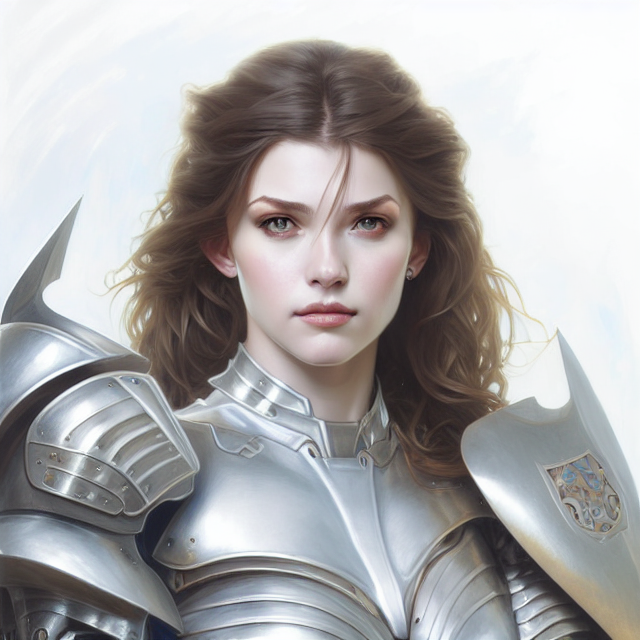

In [ ]:
#@title Prompting:
#@markdown `note: this script will go through the prompt list`<br>

##@markdown

import re
import random

# create a list of all the prompts from new line:
if type(promptsA) is str:
  promptsA = [i for i in promptsA.split('\n') if i]

# create a list of all the init images from new line:
if type(init_imgs_list) is str:
  init_imgs_list = [i for i in init_imgs_list.split('\n') if i]

def clean_string(s):
    s = ''.join([c for c in s if (re.match('[a-zA-Z0-9 _]', c) or ord(c) > 127)]).strip()
    if len(s) > 200:
        return (s[:150]).strip()
    return s

##@markdown Shared Prompt Ending:
outputFolder = "nameOfFolder" #@param {type:"string"}
opt.outdir = os.path.join(outputs_path, outputFolder)

#@markdown Prompt Template (set to none if you rather type your prompt details):
promptTemplate = 'none/custom' #@param ["none/custom","character - female adult", "character - male adult", "environment - scifi", "environment - fantasy", "vehicle - sketch", "vehicle - render", "style - anime keyframe (use high guidance scale of 15+)", "style - comic art inks", "style - blackwork / heavily inked tattoos", "fun - action figure character", "fun - stickers", "fun - marble statue"]
templateSelected = "none"
templateSelectedStart = ""
templateSelectedKey = 0

if promptTemplate == "none/custom":
  templateSelectedKey = 0
elif promptTemplate == "character - female adult":
  templateSelectedKey = 1
elif promptTemplate == "character - male adult":
  templateSelectedKey = 2
elif promptTemplate == "environment - scifi": 
  templateSelectedKey = 3
elif promptTemplate == "environment - fantasy": 
  templateSelectedKey = 4
elif promptTemplate == "vehicle - sketch": 
  templateSelectedKey = 5
elif promptTemplate == "vehicle - render": 
  templateSelectedKey = 6
elif promptTemplate == "style - anime keyframe (use high guidance scale of 15+)": 
  templateSelectedKey = 7
elif promptTemplate == "style - comic art inks": 
  templateSelectedKey = 8
elif promptTemplate == "style - blackwork / heavily inked tattoos": 
  templateSelectedKey = 9
elif promptTemplate == "fun - action figure character": 
  templateSelectedKey = 10
elif promptTemplate == "fun - stickers": 
  templateSelectedKey = 11
elif promptTemplate == "fun - marble statue": 
  templateSelectedKey = 12

# code for determining which key is selected:
# templateSelectedKey = 6
promptTemplatedSelectedlist = promptTemplateDict[int(templateSelectedKey)] # gets both the values of the selected key as a list, ex ['male', 'line art']
templateSelectedStart = promptTemplatedSelectedlist[0]
templateSelected = promptTemplatedSelectedlist[1]
# end template prompt list ------------------------------------------------------------

emotiveTemplate = 'none' #@param ["none", "happy", "angry", "sad", "zombie", "psychedelic", "sketchy drawing style"]
emoteTemplateSelected = "none"
if emotiveTemplate == "none":
  emoteTemplateSelected = "none"

elif emotiveTemplate == "happy":
  emoteTemplateSelected = "happy friendly cheerful smiling joy sparkling magical"

elif emotiveTemplate == "angry":
  emoteTemplateSelected = "villain angry pissed off frowning yelling spitting fighting violent extreme anger rage fury outrage furious open mouth"

elif emotiveTemplate == "sad":
  emoteTemplateSelected = "depressed sad saddened heartbroken pouting crying tears frown grief grieving hopeless whimpering"

elif emotiveTemplate == "zombie":
  emoteTemplateSelected = "black dark very dark black and creepy horror terrifying bloody gore wounds blood splats zombie terrified dead"

elif emotiveTemplate == "psychedelic":
  emoteTemplateSelected = "psychedelic trippy colorful neon kaleidoscope mushrooms trance bright mind-blowing mystical spiritual mysticism psilocybin hallucinogenic"

elif emotiveTemplate == "sketchy drawing style":
  emoteTemplateSelected = "line art line drawing pen and ink black and white simple simplified sketch drawing pencil drawing rough thin lines line linear etched flat drawing"

# end template emotive addition list -----------------------------------------------------------

randomEnd = "" #@param {type:"string"}
randomStringEnd = randomEnd.split(",")
numOfRandomStringEnd = len(randomStringEnd)
wordRNDMend = ""

# custom prompt settings if 'none' template selected:
#@markdown Prompt Details (these values are included on EVERY prompt in the list if no template is used):
randomStart = "female" #@param {type:"string"}
wordRNDM = ""
randomStringLS = randomStart.split(",")
numOfRandomStringStart = len(randomStringLS)
midDetails = "portrait, young woman, detailed gorgeous face, digital art, painting, artstation, concept art, smooth, sharp focus, high definition, detailed" #@param {type:"string"}
endingStyle = "illustration, art by artgerm and greg rutkowski and alphonse mucha" #@param {type:"string"}
# next we determine if we should actually use these custom strings or use our prompt templates:
promptsB = ""
if templateSelectedKey == 0:
  promptsB = [x + ", " + midDetails for x in promptsA] # add the universal style text to each prompt in the list
  prompts = [x + ", " + endingStyle for x in promptsB] # add the universal style text to each prompt in the list
else:
  prompts = [x + ", " + templateSelected for x in promptsA] # add the universal style text to each prompt in the list

#@markdown Basic Settings:
width = 700 #@param {type:"integer"}
height = 700 #@param {type:"integer"}
width_height = [width, height] # param{type: 'raw'}
guidance_scale = 16 #@param {type:"slider", min:0, max:40, step:1}
steps = 78 #@param {type:"integer"}
samples_per_batch = 1 # not exposed, you can do 2 or more based on GPU ram, if get CUDA out of memory need to restart runtime
number_of_images = 1 #param {type:"integer"}
number_of_repeats = 3 #@param {type:"integer"}
sampler = 'ddim' #@param ["klms","plms", "ddim"]
ddim_eta = 0.75 # param {type:"number"}

#@markdown Init image
randomizeImageFromFolder = False#@param{type:"boolean"}
initial_image = "" #@param {type:"string"}
checkForInitial_Image = len(initial_image)
if checkForInitial_Image == 0:
  init_image_or_folder = "/content/init_image/"
else:
  init_image_or_folder = "/content/init_image/" + initial_image
init_strength = 0.25 #@param {type:"number"}

#@markdown Sequence Settings
seed = -1 # @param {type:"integer"}
firstPromptOnly = True#@param{type:"boolean"}
#@markdown `Note: Can iterate on a seed through the scales to see how the values affects results, or randomize:`
# these options would run 14 times:
init_strength_0_to_1 = False#@param{type:"boolean"}
cfg_scale_7_to_20 = False#@param{type:"boolean"}
cycleThroughPromptList = False#@param{type:"boolean"}
# for template cycling, ex generating both male and female or sketch after the other:
templatesToCycle = "1,2,3,4,5,7,8,9" #@param {type:"string"}
listOfTemplatesToCycle = templatesToCycle.split(",")
numOfTemplatesToCycle = len(listOfTemplatesToCycle)
# end template cycle variables-----
init_strength_random = False#@param{type:"boolean"}
cfg_scale_random = False#@param{type:"boolean"}
save_settings_file = True#param{type:"boolean"} # it seems to break script if this is set to False, so I hid it


# Sequence Counter for evaluating cfg and init_strength scales:
areBothScalesToGen = False
if init_strength_0_to_1 == True:
  firstPromptOnly = True
  if cfg_scale_7_to_20 == True:
    number_of_repeats = 80 # value if both options are selected
    areBothScalesToGen = True
  else:
    number_of_repeats = 10
if cfg_scale_7_to_20 == True:
  firstPromptOnly = True
  if init_strength_0_to_1 == True:
    number_of_repeats = 80 # value if both options are selected
    areBothScalesToGen = True
  else:
    number_of_repeats = 8
counterCFG = 6
counterINITSTRENGTH = 0
counter = 0
countRepeats = -1
number_of_repeats_display = number_of_repeats
randomNumber = 0
countPromptTemplateCycles = -1

if firstPromptOnly == True:
  number_of_repeats_display = number_of_repeats
else:
  number_of_repeats_display = number_of_repeats * len(prompts)

# check if we're cycling through prompt templates:
if cycleThroughPromptList == True:
  if init_strength_0_to_1 == False and cfg_scale_7_to_20 == False:
    number_of_repeats = numOfTemplatesToCycle * len(prompts)
    number_of_repeats_display = number_of_repeats

# --------- CODE STARTS GENERATING ----------------
for x in range(number_of_repeats):
  countRepeats +=1
  # These counters count every time the prompt is sent for another repeat
  if firstPromptOnly == True:
    if init_strength_0_to_1 == False or cfg_scale_7_to_20 == False:
      counter = counter
  else:
    if init_strength_0_to_1 == False:
      counter = 0
    if cfg_scale_7_to_20 == False:
      counter = 0
  if init_strength_0_to_1 == True or cfg_scale_7_to_20 == True:
    if countRepeats == number_of_repeats:
      break

  # check if we're cycling through prompt templates and need to swap the prompt text:
  if cycleThroughPromptList == True:
    countPromptTemplateCycles += 1
    if templateSelectedKey == number_of_repeats: # prevents the list going out of range
      break
    try:
      templateSelectedKey = listOfTemplatesToCycle[countPromptTemplateCycles] # for some reason this line turns the into to string, so have to turn it back to int
    except:
      break
    promptTemplatedSelectedlist = promptTemplateDict[int(templateSelectedKey)] # gets both the values of the selected key as a list, ex ['male', 'line art']
    templateSelectedStart = promptTemplatedSelectedlist[0]
    templateSelected = promptTemplatedSelectedlist[1]
    prompts = [x + ", " + templateSelected for x in promptsA] # add the universal style text to each prompt in the list


  # calculating the full prompt: ----------------------------------
  for prompt in prompts:
  # check if we are only supposed to generate the first prompt or all them:
    if firstPromptOnly == True:
      if prompt == prompts[1]:
        break

    # the random start and end words are broken, for some reason
    if numOfRandomStringStart != 0 and numOfRandomStringStart != 1:
      # wordRNDM = random.choice(randomStringLS) # trash line didn't run properly
      number = ((seed - seed) + (numOfRandomStringStart - 1))
      randomNumber = random.randint(0, number)
      # print(numOfRandomStringStart)
      if randomNumber > numOfRandomStringStart or randomNumber <0:
        randomNumber = 0
      wordRNDM = randomStringLS[randomNumber]
    elif numOfRandomStringStart == 1:
      wordRNDM = randomStringLS[0]
    #print(randomNumber)
    #print(wordRNDM)

    if numOfRandomStringEnd != 0 and numOfRandomStringEnd != 1:
      # wordRNDMend = random.choice(randomStringEnd) # this trash didn't work for some reason
      number = ((seed - seed) + (numOfRandomStringEnd - 1))
      randomNumber = random.randint(0, number)
      if randomNumber > numOfRandomStringEnd or randomNumber <0:
        randomNumber = 0
      wordRNDMend = randomStringEnd[randomNumber]
    elif numOfRandomStringEnd == 1:
      wordRNDMend = randomStringEnd[0]

    if templateSelected != "none":
      randomStringLS = templateSelectedStart
      wordRNDM = templateSelectedStart

    # opt.prompt = prompt
    if numOfRandomStringStart == 0:
      if numOfRandomStringEnd == 0:
        promptPreFinal = prompt
      else:
        if len(wordRNDMend) == 0:
          promptPreFinal = prompt
        else:
          promptPreFinal = prompt + "," + wordRNDMend
    else:
      if numOfRandomStringEnd == 0:
        promptPreFinal = wordRNDM + ", " + prompt
      else:
        if len(wordRNDMend) == 0:
          promptPreFinal = wordRNDM + ", " + prompt
        else:
          promptPreFinal = wordRNDM + ", " + prompt + "," + wordRNDMend

    # finally bring the combined prompt together:
    if emoteTemplateSelected == "none":
      opt.prompt = promptPreFinal
    else:
      opt.prompt = promptPreFinal + " " + emoteTemplateSelected

    shortenedPromptNameList = opt.prompt.split()[:4]
    shortenedPromptNameStr = " ".join(shortenedPromptNameList)
    batch_name = clean_string(shortenedPromptNameStr) # shorten the prompt word since the prompts are too long for windows!
    # opt.outdir = os.path.join(outputs_path, batch_name) # if you want output dir to match the prompt
    if randomizeImageFromFolder == True:
      opt.init_img = init_image_or_folder
    if randomizeImageFromFolder == False:
      if checkForInitial_Image == 0: # we have to check if user wants to run a single specific image (meaning the field in the init image area)
        if firstPromptOnly == False:
          full_init_img_path = init_image_or_folder + init_imgs_list[counter]
        else:
          full_init_img_path = init_image_or_folder + init_imgs_list[0]
      else:
        full_init_img_path = init_image_or_folder
      print("Init image used: " + full_init_img_path)
      opt.init_img = full_init_img_path
    opt.ddim_steps = steps
    opt.n_iter = 1
    opt.n_samples = samples_per_batch

    # CFG Calculation:    
    opt.sampler = sampler
    if cfg_scale_7_to_20 == False:
      opt.scale = guidance_scale
    else:
      opt.scale = counterCFG
    if cfg_scale_random == True:
      opt.scale = random.uniform(7, 20)

    opt.seed = random.randint(0, 2**32) if seed == -1 else seed

    # INIT IMAGE:
    if init_strength_0_to_1 == True:
      init_strength = counterINITSTRENGTH
    if init_strength_random == True:
      init_strength = random.uniform(0.1, 0.8)
    opt.strength = max(0.0, min(1.0, 1.0 - init_strength))

    #opt.W = width_height[0]
    #opt.H = width_height[1]
    opt.W, opt.H = map(lambda x: x - x % 64, (width_height[0], width_height[1])) # resize to integer multiple of 64

    # Counters:
    counter += 1 # I added this to keep track of INIT images
    if firstPromptOnly == True:
      if cycleThroughPromptList == True:
        print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle))
      else: 
        print("Generation processing: " + str(counter) + " / " + str(number_of_repeats_display))    
    else:
        displayCounter = (len(prompts) * countRepeats) + counter
        if cycleThroughPromptList == True:
          print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle))
        else:        
          print("Generation processing: " + str(displayCounter) + " / " + str(number_of_repeats_display))
    if areBothScalesToGen == False:
      counterCFG += 2 # go up from 7 to 20 if activated
      counterINITSTRENGTH = counterINITSTRENGTH + 0.1 # go up from 0.1 to 0.8 if activated
    else:
      counterINITSTRENGTH = counterINITSTRENGTH + 0.1
      if counterINITSTRENGTH > 0.9:
        counterINITSTRENGTH = 0 # reset since we're now going to go to next CFG
        counterCFG += 2 # go up from 7 to 20 if activated

    if opt.strength >= 1 or init_image_or_folder == None:
        opt.init_img = ""

    if opt.init_img != None and opt.init_img != '':
        opt.sampler = 'ddim'

    if opt.sampler != 'ddim':
        opt.ddim_eta = 0.0

    # debugging during processing:
    print("prompt: " + opt.prompt[:110] +"...")

    # save settings
    settings = {
        'ddim_eta': ddim_eta,
        'guidance_scale': guidance_scale,
        'init_image': init_image_or_folder,
        'init_strength': init_strength,
        'number_of_images': number_of_images,
        'prompt': opt.prompt,
        'sampler': sampler,
        'samples_per_batch': samples_per_batch,
        'seed': opt.seed,
        'steps': steps,
        'width': opt.W,
        'height': opt.H,
    }
    os.makedirs(opt.outdir, exist_ok=True)
    while os.path.isfile(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt"):
        batch_idx += 1
    if save_settings_file:
      with open(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt", "w+", encoding="utf-8") as f:
          json.dump(settings, f, ensure_ascii=False, indent=4)
    with open(f"{opt.outdir}/prompt.txt", 'w') as f:
          f.write(opt.prompt)
    sample_idx = 0

    for i in range(number_of_images):
        gc.collect()
        torch.cuda.empty_cache()

        images = generate(opt)

        clear_output(wait=True)
        print(f"Used seed: {opt.seed}")
        if firstPromptOnly == True:
          if cycleThroughPromptList == True:
            print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle))
          else:
            print("Generations processed: " + str(counter) + " / " + str(number_of_repeats_display))
        else:
          if cycleThroughPromptList == True:
            print("Generations processed: " + str(counter) + " / " + str(numOfTemplatesToCycle))
          else:
            print("Generations processed: " + str(displayCounter) + " / " + str(number_of_repeats_display))
        # print(f"Saved to: {opt.outdir}")
        print("prompt: " + opt.prompt[:110] +"...")
        for image in images:
            display(image)

        opt.seed += 1
